# Importing all necessary libraries

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
import pickle

# Preprocessing Libraries
from sklearn.preprocessing import RobustScaler

# Model training libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from imblearn.under_sampling import NearMiss               # For Undersampling
from imblearn.over_sampling import RandomOverSampler       # For Oversampling
from imblearn.combine import SMOTETomek                    # For Both Undersampling & Oversampling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, precision_score, f1_score

## Reading/Importing the dataset
### --- Dataset details ---
- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction
- Dataset link---https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

In [ ]:
df=pd.read_csv('frauddetection.csv')
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# Checking if there are any null values in our dataset
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Visualization

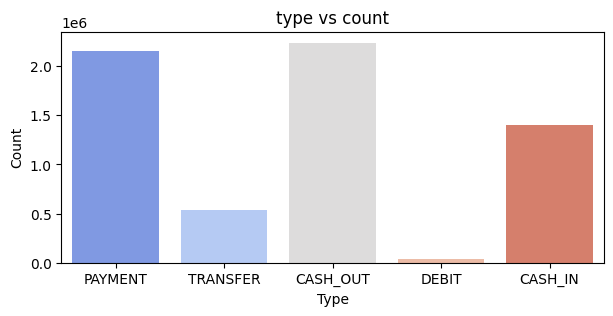

In [ ]:
# Countplot of 'type'
plt.figure(figsize=(7,3))
plt.title('type vs count')
sns.countplot(data=df,x='type',palette='coolwarm')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

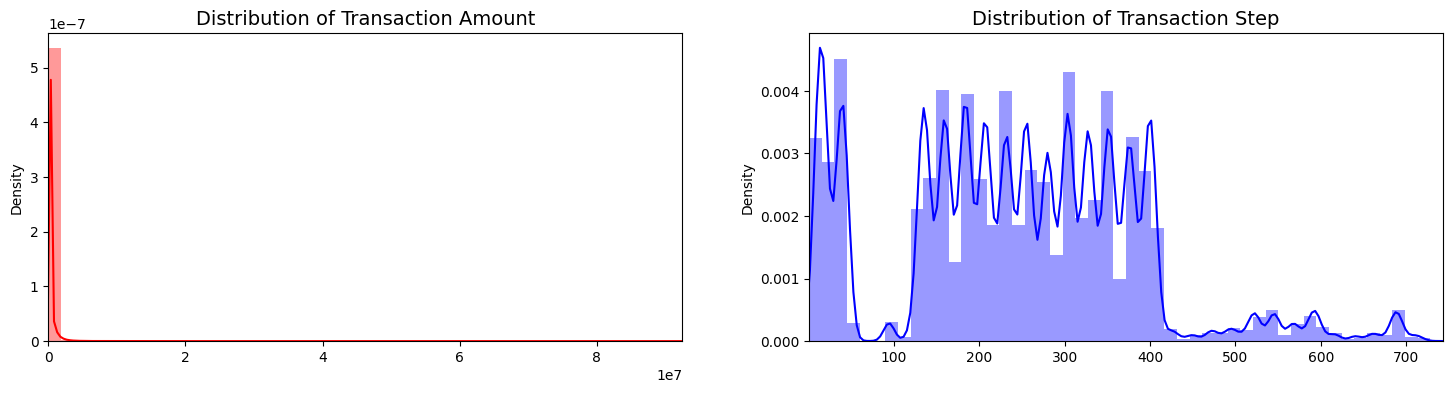

In [ ]:
# Plotting subplot for amount and time column
fig, ax = plt.subplots(1, 2, figsize=(18,4))
amount_val = df['amount'].values
time_val = df['step'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Step', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])
plt.show()

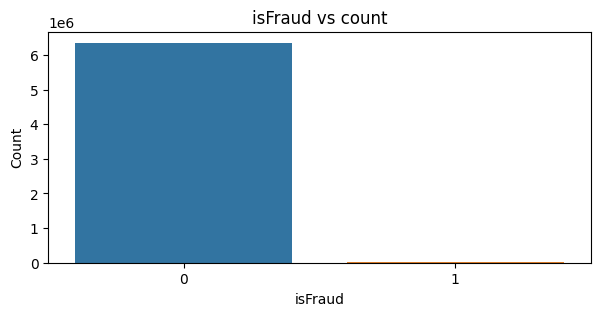

In [ ]:
# Countplot of 'isFraud'
plt.figure(figsize=(7,3))
plt.title('isFraud vs count')
sns.countplot(data=df,x='isFraud')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()

#### NOTE:- We can see from above visualization it is an imbalanced dataset .

In [ ]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
# Let's look at the percentage of each category in isFraud column(target column)
print("No Frauds:",df['isFraud'].value_counts()[0]/len(df['isFraud'])*100)
print("Frauds:",df['isFraud'].value_counts()[1]/len(df['isFraud'])*100)

No Frauds: 99.87091795518198
Frauds: 0.12908204481801522


In [ ]:
numerical=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

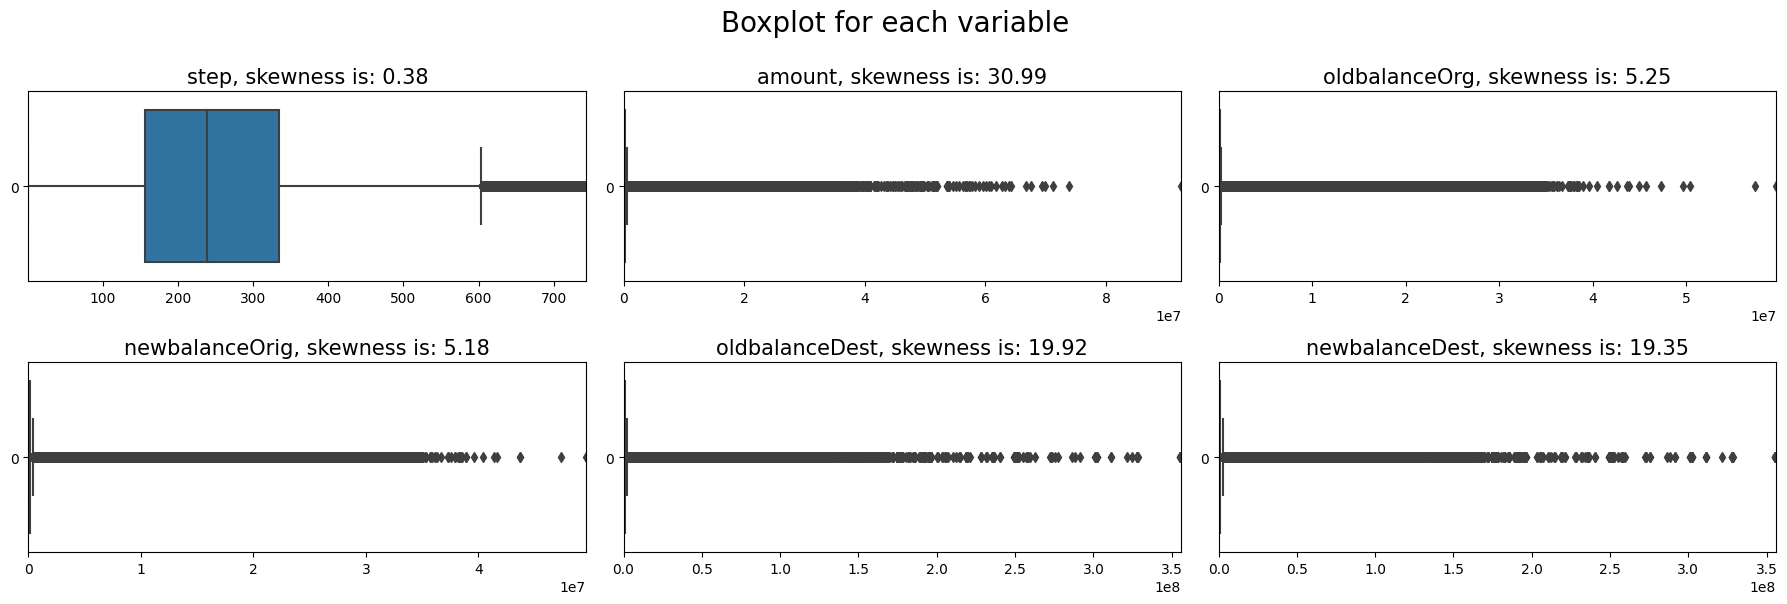

In [ ]:
# Boxplot for each variable in numerical list
def boxplots_visual(data,column):
    fig, ax = plt.subplots(2,3,figsize=(18,6))
    fig.suptitle('Boxplot for each variable',y=1, size=20)
    ax=ax.flatten()
    for i,feature in enumerate(column):
        sns.boxplot(data=data[feature],ax=ax[i], orient='h')
        ax[i].set_title(feature+ ', skewness is: '+str(round(data[feature].skew(axis = 0, skipna = True),2)),fontsize=15)
        ax[i].set_xlim([min(data[feature]), max(data[feature])])
boxplots_visual(data=df,column=numerical)
plt.tight_layout()

In [ ]:
# Checking nameOrig,nameDest column
nameOrig=df['nameOrig'].unique()
print("Unique in nameOrig:",len(nameOrig))
print(nameOrig)

nameDest=df['nameDest'].unique()
print("Unique in nameDest:",len(nameDest))
print(nameDest)

Unique in nameOrig: 6353307
['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807']
Unique in nameDest: 2722362
['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513']


In [ ]:
# Checking isFlaggedFraud column
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [ ]:
# Dropping columns that are not needed
df.drop(['step','nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

In [ ]:
# Applying onehot encoding on type column
df=pd.get_dummies(data=df,columns=['type'],drop_first=True)
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [ ]:
# We are using RobustScaler to scale down the numerical features as RobustScaler is less prone to outliers
scale=RobustScaler()
numerical=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
for feature in numerical:
    df[feature]=scale.fit_transform(df[feature].values.reshape(-1, 1))
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.332932,1.452991,1.111175,-0.140722,-0.193057,0,0,0,1,0
1,-0.373762,0.065610,0.134375,-0.140722,-0.193057,0,0,0,1,0
2,-0.382380,-0.130708,0.000000,-0.140722,-0.193057,1,0,0,0,1
3,-0.382380,-0.130708,0.000000,-0.118260,-0.193057,1,1,0,0,0
4,-0.323571,0.254820,0.207169,-0.140722,-0.193057,0,0,0,1,0


## Model Training

In [ ]:
# Splitting our data into independent and dependent features
x=df.drop('isFraud',axis=1)
y=df['isFraud']

In [ ]:
# Feature Importance
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(x,y)
print(model.feature_importances_)

[0.29382095 0.31963475 0.09431257 0.067209   0.21263254 0.0063724
 0.         0.         0.00601779]


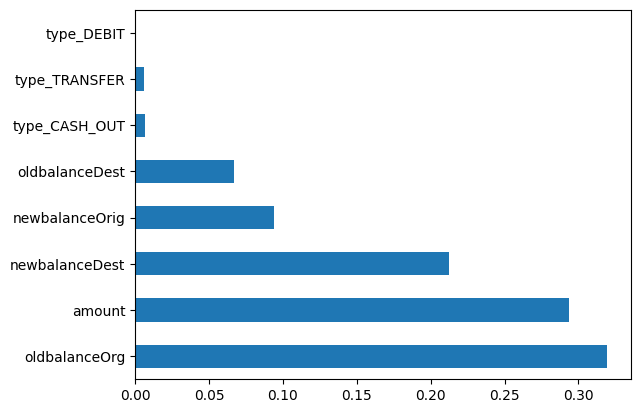

In [ ]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

In [ ]:
# Doing train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,train_size=0.7)

#### Training with Logistic Regression using StratifiedKFold

In [ ]:
# Applying StratifiedKFold
skf=StratifiedKFold(n_splits=3, shuffle=False, random_state=None)
lr=LogisticRegression()
param={'C':10.0 **np.arange(-1,1)}
test1=RandomizedSearchCV(lr,param,cv=skf,n_jobs=-1,scoring='accuracy')
test1.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([0.1, 1. ])},
                   scoring='accuracy')

In [ ]:
y_pred=test1.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[1906197     169]
 [   1293    1127]]


Accuracy Score: 
 0.9992340681459315


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906366
           1       0.87      0.47      0.61      2420

    accuracy                           1.00   1908786
   macro avg       0.93      0.73      0.80   1908786
weighted avg       1.00      1.00      1.00   1908786



#### Training with RandomForestClassifier by setting class_weight

In [ ]:
test2=RandomForestClassifier(class_weight={0:1,1:100})
test2.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 100})

In [ ]:
y_pred=test2.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[1906285      51]
 [    553    1897]]


Accuracy Score: 
 0.9996835685089894


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906336
           1       0.97      0.77      0.86      2450

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



#### NOTE:-  RandomForestClassifier has better result

### Under Sampling

In [ ]:
ns=NearMiss()
X_train_ns,y_train_ns=ns.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 4448071, 1: 5763})
The number of classes after fit Counter({0: 5763, 1: 5763})


In [ ]:
model1=RandomForestClassifier()
model1.fit(X_train_ns,y_train_ns)

RandomForestClassifier()

In [ ]:
y_pred=model1.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[ 634290 1272046]
 [    100    2350]]


Accuracy Score: 
 0.3335313649618134


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.33      0.50   1906336
           1       0.00      0.96      0.00      2450

    accuracy                           0.33   1908786
   macro avg       0.50      0.65      0.25   1908786
weighted avg       1.00      0.33      0.50   1908786



### Over Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler()
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 4448071, 1: 5763})
The number of classes after fit Counter({0: 4448071, 1: 4448071})


In [ ]:
model2=RandomForestClassifier()
model2.fit(X_train_ns,y_train_ns)

RandomForestClassifier()

In [ ]:
y_pred=model2.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[1906192     144]
 [    444    2006]]


Accuracy Score: 
 0.9996919508001421


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906336
           1       0.93      0.82      0.87      2450

    accuracy                           1.00   1908786
   macro avg       0.97      0.91      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



### SMOTETomek(Do both undersampling and oversampling)

In [ ]:
smt=SMOTETomek()
X_train_ns,y_train_ns=smt.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 4448071, 1: 5763})
The number of classes after fit Counter({0: 4447442, 1: 4447442})


In [ ]:
model3=RandomForestClassifier()
model3.fit(X_train_ns,y_train_ns)

RandomForestClassifier()

In [23]:
y_pred=model3.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[1905168    1168]
 [    105    2345]]


Accuracy Score: 
 0.9993330839601715


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906336
           1       0.67      0.96      0.79      2450

    accuracy                           1.00   1908786
   macro avg       0.83      0.98      0.89   1908786
weighted avg       1.00      1.00      1.00   1908786



#### Over Sampling has better results

In [ ]:
# open a file, where you want to store the data
file = open('fraud_prediction.pkl', 'wb')

# dump information to that file
pickle.dump(model2, file)
file.close()

In [ ]:
myfile = open('fraud_prediction.pkl','rb')
mymodel = pickle.load(myfile)
myprediction = mymodel.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,myprediction))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,myprediction))
print('\n')
print("Classification Report: \n",classification_report(y_test,myprediction))

Confusion Matrix: 
 [[1906192     144]
 [    444    2006]]


Accuracy Score: 
 0.9996919508001421


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906336
           1       0.93      0.82      0.87      2450

    accuracy                           1.00   1908786
   macro avg       0.97      0.91      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

